In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

# ## Grab the config we'll use in this example
# !mkdir configs
# !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached pytorch_lightning-1.4.9-py3-none-any.whl (925 kB)


  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.2.0
    Uninstalling pytorch-lightning-1.2.0:
      Successfully uninstalled pytorch-lightning-1.2.0


'\nRemember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!\nAlternatively, you can uncomment the exit() below to crash and restart the kernel, in the case\nthat you want to use the "Run All Cells" (or similar) option.\n'

In [30]:
# Load model configs
BRANCH = 'main'

!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/quartznet/quartznet_15x5.yaml
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/citrinet/citrinet_512.yaml
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/citrinet/config_bpe.yaml


mkdir: cannot create directory ‘configs’: File exists
--2021-10-25 14:01:58--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4040 (3,9K) [text/plain]
Saving to: ‘configs/config.yaml.14’

config.yaml.14      100%[===================>]   3,95K  --.-KB/s    in 0s      

2021-10-25 14:01:58 (27,6 MB/s) - ‘configs/config.yaml.14’ saved [4040/4040]

--2021-10-25 14:01:58--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/quartznet/quartznet_15x5.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... c

In [2]:
import glob
import os
import subprocess
import tarfile
import wget

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import nemo
import nemo.collections.asr as nemo_asr

import fastwer

import json
import librosa

import librosa
import json
import copy

from omegaconf import DictConfig
import copy

[NeMo W 2021-10-27 19:24:05 optimizers:47] Apex was not found. Using the lamb optimizer will error out.
[NeMo W 2021-10-27 19:24:05 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[NeMo W 2021-10-27 19:24:05 nmse_clustering:54] Using eigen decomposition from scipy, upgrade torch to 1.9 or higher for faster clustering
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2021-10-27 19:24:05 nemo_logging:34

In [3]:
data_dir = '../../'
datasets_dir = '../../datasets/'

In [ ]:
# --- Building Manifest Files --- #

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    metadata_df = pd.DataFrame(columns=['file_name', 'transcript'])
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                metadata_df = metadata_df.append(pd.DataFrame({'file_name':audio_path, 'transcript':transcript}, index=[1]), \
                                                 ignore_index=True)
                json.dump(metadata, fout)
                fout.write('\n')
    metadata_df.to_csv(datasets_dir + 'an4/metadata.csv')
    
    
# Building Manifests
print("******")
train_transcripts = datasets_dir + 'an4/etc/an4_train.transcription'
train_manifest_an4 = datasets_dir + 'an4/train_manifest.json'
build_manifest(train_transcripts, train_manifest_an4, 'datasets/an4/wav/an4_clstk')
print("Training manifest created.")

test_transcripts = datasets_dir + '/an4/etc/an4_test.transcription'
test_manifest_an4 = datasets_dir + '/an4/test_manifest.json'
build_manifest(test_transcripts, test_manifest_an4, 'datasets/an4/wav/an4test_clstk')
print("Test manifest created.")
print("***Done***")

In [4]:
# --- Building Manifest Files For LJSpeech --- #

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path, test_size=0.2, random_state=42):
    with open(transcripts_path, 'r') as fin:
        metadata = pd.read_csv(fin, sep='|', names=['file_name', 'transcript', 'normalized'])
        metadata['transcript'] = metadata['transcript'].apply(lambda x: x.lower())
        metadata_train, metadata_test = train_test_split(metadata, test_size=test_size, random_state=random_state)
        for m, m_path in [(metadata_train, 'train_manifest.json'), (metadata_test, 'test_manifest.json')]:
            with open(manifest_path + m_path, 'w') as fout:
                for row in m.iterrows():
                    file_id = row[1]['file_name']  # e.g. "cen4-fash-b"
                    audio_path = os.path.join(
                        manifest_path, wav_path, file_id + '.wav')

                    duration = librosa.core.get_duration(filename=audio_path)

                    transcript = row[1]['transcript']

                    # Write the metadata to the manifest
                    metadata = {
                        "audio_filepath": audio_path,
                        "duration": duration,
                        "text": transcript
                    }
                    json.dump(metadata, fout)
                    fout.write('\n')
        metadata_train.to_csv(datasets_dir + 'LJSpeech-1.1/metadata_train.csv')
        metadata_test.to_csv(datasets_dir + 'LJSpeech-1.1/metadata_test.csv')
    
# Building Manifests
print("******")
train_transcripts = datasets_dir + '/LJSpeech-1.1/metadata.csv'
manifest = datasets_dir + '/LJSpeech-1.1/'
train_manifest_ljspeech = manifest + 'train_manifest.json'
test_manifest_ljspeech = manifest + 'train_manifest.json'
build_manifest(train_transcripts, manifest, 'wavs')
print("Manifests created.")

******
Manifests created.


In [5]:
pd.read_csv(datasets_dir + 'LJSpeech-1.1/metadata_train.csv')

,Unnamed: 0,file_name,transcript,normalized
0,5758,LJ019-0224,with the reduction of numbers to be accommodat...,With the reduction of numbers to be accommodat...
1,4244,LJ015-0144,developed to a colossal extent the frauds he h...,developed to a colossal extent the frauds he h...
2,9517,LJ036-0123,unloaded at 500 north beckley at 12:45 p.m.,unloaded at five hundred North Beckley at twel...
3,415,LJ002-0231,there was no distinct place for the female deb...,There was no distinct place for the female deb...
4,12024,LJ046-0224,the state department advised the secret servic...,The State Department advised the Secret Servic...
...,...,...,...,...
10475,11964,LJ046-0164,prs investigated 34 newly established or react...,PRS investigated thirty-four newly established...
10476,5191,LJ018-0055,"he is described as not a bad-looking man, with...","He is described as not a bad-looking man, with..."
10477,5390,LJ018-0254,"he declined to plead, but a plea of ""not guilt...","He declined to plead, but a plea of ""Not Guilt..."
10478,860,LJ003-0339,could possibly afford.,could possibly afford.


In [6]:
# nemo_asr.models.EncDecCTCModelBPE.list_available_models()

In [7]:
# List of models 

# EncDecCTCModel
# quartznet15x5 = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")
# asr_talknet_aligner = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="asr_talknet_aligner")

# EncDecCTCModelBPE
# stt_en_citrinet_256 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_256")
# stt_en_citrinet_512 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_512")
# stt_en_citrinet_1024
stt_en_citrinet_256_gamma_0_25 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_256_gamma_0_25")
# stt_en_citrinet_512_gamma_0_25 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_256_gamma_0_25")
# stt_en_citrinet_1024_gamma_0_25 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_1024_gamma_0_25")
# stt_en_conformer_ctc_small = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_conformer_ctc_small")
# stt_en_conformer_ctc_medium
# stt_en_conformer_ctc_large
# stt_en_conformer_ctc_small_ls = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_conformer_ctc_small_ls")
# stt_en_conformer_ctc_medium_ls
# stt_en_conformer_ctc_large_ls


[NeMo I 2021-10-27 19:24:11 cloud:56] Found existing object /home/boris/.cache/torch/NeMo/NeMo_1.4.0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo.
[NeMo I 2021-10-27 19:24:11 cloud:62] Re-using file from: /home/boris/.cache/torch/NeMo/NeMo_1.4.0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo
[NeMo I 2021-10-27 19:24:11 common:702] Instantiating model from pre-trained checkpoint
[NeMo I 2021-10-27 19:24:12 mixins:149] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2021-10-27 19:24:12 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2021-10-27 19:24:12 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2021-10-27 19:24:12 modelPT:144] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2021-10-27 19:24:12 features:262] PADDING: 16
[NeMo I 2021-10-27 19:24:12 features:279] STFT using torch
[NeMo I 2021-10-27 19:24:15 save_restore_connector:143] Model EncDecCTCModelBPE was successfully restored from /home/boris/.cache/torch/NeMo/NeMo_1.4.0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo.


In [10]:
stt_en_citrinet_512.cfg

{'sample_rate': 16000, 'train_ds': {'manifest_filepath': None, 'sample_rate': 16000, 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None}, 'validation_ds': {'manifest_filepath': None, 'sample_rate': 16000, 'batch_size': 32, 'shuffle': False}, 'test_ds': {'manifest_filepath': ['/home/smajumdar/PycharmProjects/nemo-eval/nemo_eval/librispeech/manifests/dev_other.json'], 'sample_rate': 16000, 'batch_size': 32, 'shuffle': False, 'num_workers': 12, 'pin_memory': True}, 'model_defaults': {'repeat': 5, 'dropout': 0.0, 'separable': True, 'se': True, 'se_context_size': -1}, 'tokenizer': {'dir': '/home/smajumdar/PycharmProjects/nemo-eval/nemo_beta_eval/asrset/manifests/asrset_1.4/tokenizers/no_appen/tokenizer_spe_unigram_v1024/', 'type': 'bpe'}, 'preprocessor': {'_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'sample_rate': 16000, 'normalize': 'per_feature', 'window_size': 0.025, 'window_st

In [12]:
first_asr_model = nemo_asr.models.EncDecCTCModelBPE.restore_from('first_model.nemo')

[NeMo I 2021-10-26 15:12:46 mixins:149] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2021-10-26 15:12:46 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: ../../datasets/LJSpeech-1.1/train_manifest.json
    sample_rate: 16000
    batch_size: 4
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    num_workers: 12
    pin_memory: true
    
[NeMo W 2021-10-26 15:12:46 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: ../../datasets/LJSpeech-1.1/train_manifest.json
    sample_rate: 16000
    batch_size: 4
    shuffle: false
    use_start_end_token: false
    num_workers: 12
   

[NeMo I 2021-10-26 15:12:46 features:262] PADDING: 16
[NeMo I 2021-10-26 15:12:46 features:279] STFT using torch
[NeMo I 2021-10-26 15:12:47 save_restore_connector:143] Model EncDecCTCModelBPE was successfully restored from /home/boris/Documents/NeMo_own_research/asr/first_model.nemo.


In [10]:
import pandas as pd
import numpy as np
import fastwer
import re

def calculate_score(dataset, model, model_name='-', k=None, log=True):
    print(f'Calculating score for model {model_name} on {dataset}')
    if dataset == 'LJSpeech':
        metadata = pd.read_csv(datasets_dir + 'LJSpeech-1.1/metadata_test.csv')
        if k is not None:
            metadata = metadata[:k]
        files = metadata['file_name'].apply(lambda x: f'{datasets_dir}/LJSpeech-1.1/wavs/{x}.wav').values
        texts = metadata['transcript'].values
    elif dataset == 'AN4':
        metadata = pd.read_csv(f'{datasets_dir}/an4/metadata.csv')
        files = metadata['file_name'].values
        texts = metadata['transcript'].values
        
    
    wer = []
    cer = []
    predictions = model.transcribe(paths2audio_files=files)
    r = np.random.randint(1, 10)
    print(texts[r])
    print(predictions[r].replace('⁇', ''))
    for i in range(len(predictions)):
        text = texts[i].lower()
        text = re.sub('[^a-zA-Z ]+', '', text)
        prediction = predictions[i]
        prediction = re.sub('[^a-zA-Z ]+', '', prediction)
        wer.append(fastwer.score_sent(text, prediction, char_level=False))
        cer.append(fastwer.score_sent(text, prediction, char_level=True))
    wer = np.array(wer)
    cer = np.array(cer)
    
    wer = wer[wer != float('+inf')]
    cer = cer[cer != float('+inf')]
    
    wer = np.round(np.mean(wer), 2)
    cer = np.round(np.mean(cer), 2)
    if log:
        print(f'wer:{np.round(wer, 2)}; cer:{np.round(cer, 2)}')
    
    return wer, cer
        
calculate_score('LJSpeech', stt_en_citrinet_256_gamma_0_25, 'quartznet_15x5', k=100)
calculate_score('AN4', stt_en_citrinet_256_gamma_0_25, 'quartznet_15x5', k=100)
# calculate_score('AN4', quartznet15x5, 'quartznet15x5', k=100)
# calculate_score('AN4', stt_en_citrinet_1024_gamma_0_25, 'quartznet15x5', k=100)



Calculating score for model quartznet_15x5 on LJSpeech


Transcribing:   0%|          | 0/25 [00:00<?, ?it/s]

a notorious miser, robert smith, had recently died in seven dials, where he had amassed a considerable fortune.
a notorious miser robert smith had recently died in seven dials where he had a massed a considerable fortune
wer:8.23; cer:3.8
Calculating score for model quartznet_15x5 on AN4


Transcribing:   0%|          | 0/33 [00:00<?, ?it/s]

one three seven
one three seven
wer:4.42; cer:1.87


(4.42, 1.87)

In [ ]:
models = [
    'QuartzNet15x5Base-En',
    'stt_en_citrinet_256',
    'stt_en_citrinet_256_gamma_0_25',
    'stt_en_conformer_ctc_small',
    'stt_en_conformer_ctc_small_ls'
]

wer_an4_list = []
cer_an4_list = []
wer_ljspeech_list = []
cer_ljspeech_list = []

for model_name in models:
    try:
        model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name=model_name)
    except Exception:
        model = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name=model_name)
    wer_an4, cer_an4 = calculate_score('AN4', model, model_name)
    wer_ljspeech, cer_ljspeech = calculate_score('LJSpeech', model, model_name, k=100)
    
    wer_an4_list.append(wer_an4)
    cer_an4_list.append(cer_an4)
    wer_ljspeech_list.append(wer_ljspeech)
    cer_ljspeech_list.append(cer_ljspeech)

Text(0, 0.5, 'WER')

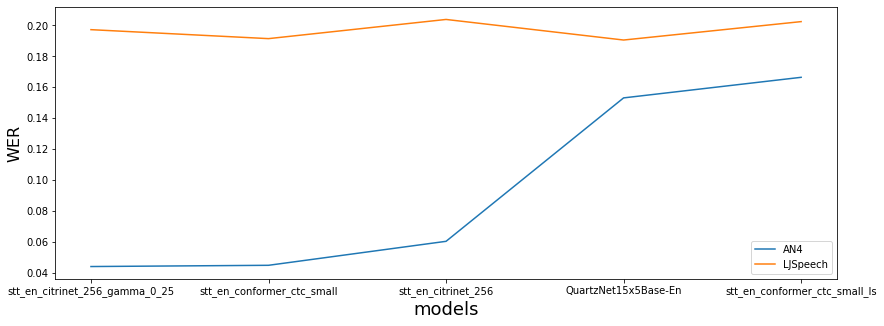

In [100]:
import matplotlib.pyplot as plt

order = np.argsort(wer_an4_list)

fig = plt.figure(figsize=(14,5))

plt.plot(np.array(models)[order], np.array(wer_an4_list)[order] / 100, label='AN4')
plt.plot(np.array(models)[order], np.array(wer_ljspeech_list)[order] / 100, label='LJSpeech')

leg = plt.legend()

plt.xlabel('models', fontsize=18)
plt.ylabel('WER', fontsize=16)

Text(0, 0.5, 'CER')

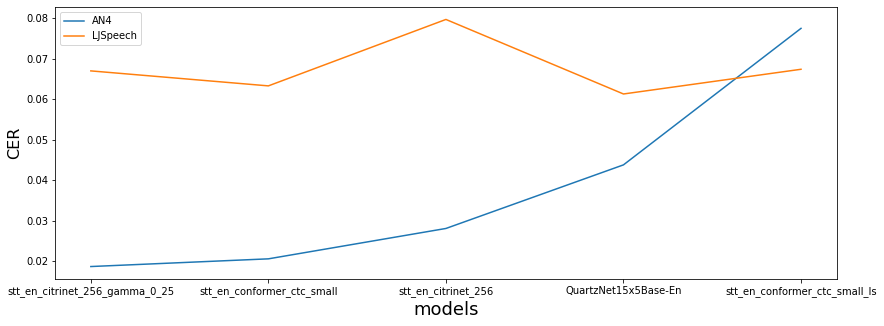

In [101]:
fig = plt.figure(figsize=(14,5))

plt.plot(np.array(models)[order], np.array(cer_an4_list)[order] / 100, label='AN4')
plt.plot(np.array(models)[order], np.array(cer_ljspeech_list)[order] / 100, label='LJSpeech')

leg = plt.legend()

plt.xlabel('models', fontsize=18)
plt.ylabel('CER', fontsize=16)

In [27]:
# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML

config_path = './configs/model_config.yaml'
config_path_quartznet = './configs/quartznet_15x5.yaml'
# config_path_citrinet = './configs/citrinet_512.yaml'
# config_path_citrinet = './configs/config_bpe.yaml'
config_path_citrinet = './configs/model_config.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params_quartznet4x1 = yaml.load(f)

with open(config_path_quartznet) as f:
    params_quartznet15x5 = yaml.load(f)
    
with open(config_path_citrinet) as f:
    params_citrinet = yaml.load(f)

In [6]:
from itertools import zip_longest
from typing import Any, Callable, Dict, List, Optional

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.utilities import rank_zero_info

class PrintTableMetricsCallback(Callback):
    """Prints a table with the metrics in columns on every epoch end.
    Example::
        from pl_bolts.callbacks import PrintTableMetricsCallback
        callback = PrintTableMetricsCallback()
    Pass into trainer like so:
    .. code-block:: python
        trainer = pl.Trainer(callbacks=[callback])
        trainer.fit(...)
        # ------------------------------
        # at the end of every epoch it will print
        # ------------------------------
        # loss│train_loss│val_loss│epoch
        # ──────────────────────────────
        # 2.2541470527648926│2.2541470527648926│2.2158432006835938│0
    """

    def __init__(self) -> None:
        self.metrics: List = []

    def on_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        metrics_dict = copy.copy(trainer.callback_metrics)
        self.metrics.append(metrics_dict)
        rank_zero_info(dicts_to_table(self.metrics))
        
def dicts_to_table(
    dicts: List[Dict],
    keys: Optional[List[str]] = None,
    pads: Optional[List[str]] = None,
    fcodes: Optional[List[str]] = None,
    convert_headers: Optional[Dict[str, Callable]] = None,
    header_names: Optional[List[str]] = None,
    skip_none_lines: bool = False,
    replace_values: Optional[Dict[str, Any]] = None,
) -> str:
    """Generate ascii table from dictionary Taken from (https://stackoverflow.com/questions/40056747/print-a-list-
    of-dictionaries-in-table-form)
    Args:
        dicts: input dictionary list; empty lists make keys OR header_names mandatory
        keys: order list of keys to generate columns for; no key/dict-key should
            suffix with '____' else adjust code-suffix
        pads: indicate padding direction and size, eg <10 to right pad alias left-align
        fcodes: formating codes for respective column type, eg .3f
        convert_headers: apply converters(dict) on column keys k, eg timestamps
        header_names: supply for custom column headers instead of keys
        skip_none_lines: skip line if contains None
        replace_values: specify per column keys k a map from seen value to new value;
                        new value must comply with the columns fcode; CAUTION: modifies input (due speed)
    Example:
        >>> a = {'a': 1, 'b': 2}
        >>> b = {'a': 3, 'b': 4}
        >>> print(dicts_to_table([a, b]))
        a│b
        ───
        1│2
        3│4
    """
    # optional arg prelude
    if keys is None:
        if len(dicts) > 0:
            keys = dicts[0].keys()  # type: ignore[assignment]
        elif header_names is not None:
            keys = header_names
        else:
            raise ValueError("keys or header_names mandatory on empty input list")
    if pads is None:
        pads = [""] * len(keys)  # type: ignore[arg-type]
    elif len(pads) != len(keys):  # type: ignore[arg-type]
        raise ValueError(f"bad pad length {len(pads)}, expected: {len(keys)}")  # type: ignore[arg-type]
    if fcodes is None:
        fcodes = [""] * len(keys)  # type: ignore[arg-type]
    elif len(fcodes) != len(fcodes):
        raise ValueError(f"bad fcodes length {len(fcodes)}, expected: {len(keys)}")  # type: ignore[arg-type]
    if convert_headers is None:
        convert_headers = {}
    if header_names is None:
        header_names = keys
    if replace_values is None:
        replace_values = {}
    # build header
    headline = "│".join(f"{v:{pad}}" for v, pad in zip_longest(header_names, pads))  # type: ignore[arg-type]
    underline = "─" * len(headline)
    # suffix special keys to apply converters to later on
    marked_keys = [h + "____" if h in convert_headers else h for h in keys]  # type: ignore[union-attr]
    marked_values = {}
    s = "│".join(f"{{{h}:{pad}{fcode}}}" for h, pad, fcode in zip_longest(marked_keys, pads, fcodes))
    lines = [headline, underline]
    for d in dicts:
        none_keys = [k for k, v in d.items() if v is None]
        if skip_none_lines and none_keys:
            continue
        elif replace_values:
            for k in d.keys():
                if k in replace_values and d[k] in replace_values[k]:
                    d[k] = replace_values[k][d[k]]
                if d[k] is None:
                    raise ValueError(f"bad or no mapping for key '{k}' is None. Use skip or change replace mapping.")
        elif none_keys:
            raise ValueError(f"keys {none_keys} are None in {d}. Do skip or use replace mapping.")
        for h in convert_headers:
            if h in keys:  # type: ignore[operator]
                converter = convert_headers[h]
                marked_values[h + "____"] = converter(d)
        line = s.format(**d, **marked_values)
        lines.append(line)
    return "\n".join(lines)

In [28]:
params = params_quartznet4x1
train_manifest = train_manifest_an4
test_manifest = test_manifest_an4

In [31]:
from omegaconf import DictConfig
import pytorch_lightning as pl

callback = PrintTableMetricsCallback()

trainer = pl.Trainer(gpus=1, max_epochs=10, callbacks=[callback])

params['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest

model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

new_opt = copy.deepcopy(params_citrinet['optim'])
new_opt['lr'] = 0.001
new_opt['betas'] = [0.95, 0.25]

model.setup_optimization(optim_config=DictConfig(new_opt))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


ConfigKeyError: Key 'train_ds' is not in struct
    full_key: train_ds
    object_type=dict

In [32]:
params

{'preprocessor': {'_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'normalize': 'per_feature', 'window_size': 0.02, 'sample_rate': 16000, 'window_stride': 0.01, 'window': 'hann', 'features': 64, 'n_fft': 512, 'frame_splicing': 1, 'dither': 1e-05, 'stft_conv': False}, 'spec_augment': {'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}, 'encoder': {'_target_': 'nemo.collections.asr.modules.ConvASREncoder', 'feat_in': 64, 'activation': 'relu', 'conv_mask': True, 'jasper': [{'filters': 256, 'repeat': 1, 'kernel': [33], 'stride': [2], 'dilation': [1], 'dropout': 0.0, 'residual': False, 'separable': True}, {'filters': 256, 'repeat': 5, 'kernel': [33], 'stride': [1], 'dilation': [1], 'dropout': 0.0, 'residual': True, 'separable': True}, {'filters': 256, 'repeat': 5, 'kernel': [33], 'stride': [1], 'dilation': [1], 'dropout': 0.0, 'residual': True, 'separable': True}, {'filters': 256, 'repeat': 5, 

In [23]:
trainer.fit(quartznet15x5)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-10-25 15:40:06 modelPT:436] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-10-25 15:40:06 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2021-10-25 15:40:06 lr_scheduler:496] Scheduler not initialized as no `sched` config supplied to setup_optimizer()



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.698    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
871.3516845703125│0.9869109988212585
825.8925170898438│1.0
825.8925170898438│1.0
792.4340209960938│0.9987063407897949
792.4340209960938│0.9987063407897949
584.275390625│1.0
584.275390625│1.0
352.31671142578125│0.9935317039489746
352.31671142578125│0.9935317039489746
211.39988708496094│1.0
211.39988708496094│1.0
154.7186737060547│1.0
154.7186737060547│1.0
84.98248291015625│1.0
84.98248291015625│1.0
84.27655029296875│1.0
84.27655029296875│1.0
84.6351547241211│1.0
84.6351547241211│1.0
78.88441467285156│1.0
78.88441467285156│1.0
1.2564302682876587│0.09162303805351257


Training: 29it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 4.17 GiB already allocated; 30.69 MiB free; 4.18 GiB reserved in total by PyTorch)

In [19]:
calculate_score('LJSpeech', model, 'fine_tuned', k=100)

Calculating score for model fine_tuned on LJSpeech


Transcribing:   0%|          | 0/25 [00:00<?, ?it/s]

inf


(inf, inf)

In [79]:
df = pd.DataFrame(callback.metrics).astype(float)

In [10]:
# params_citrinet['model']['train_ds']['manifest_filepath'] = train_manifest_an4
# params_citrinet['model']['validation_ds']['manifest_filepath'] = test_manifest_an4

# callback = PrintTableMetricsCallback()

# trainer = Trainer(gpus=1, max_epochs=50, callbacks=[callback])

# citrinet_512 = nemo_asr.models.EncDecCTCModelBPE(cfg=DictConfig(params_citrinet['model']), trainer=trainer)

# new_opt = copy.deepcopy(params_citrinet['model']['optim'])
# new_opt['lr'] = 0.001
# new_opt['betas'] = [0.95, 0.25]

# citrinet_512.setup_optimization(optim_config=DictConfig(new_opt))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


InterpolationKeyError: Interpolation key 'model.model_defaults.separable' not found
    full_key: encoder.jasper[0].separable
    object_type=dict

In [ ]:
import pytorch_lightning as pl
import copy

callback = PrintTableMetricsCallback()

trainer = pl.Trainer(gpus=1, max_epochs=50, callbacks=[callback])

In [18]:
from omegaconf import DictConfig

params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest

first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

In [71]:
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001
new_opt['betas'] = [0.95, 0.25]
first_asr_model.setup_optimization(optim_config=DictConfig(new_opt))

[NeMo I 2021-10-13 14:18:33 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.95, 0.25]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2021-10-13 14:18:33 lr_scheduler:625] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fdea6e9fc90>" 
    will be used during training (effective maximum steps = 16400) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 16400
    )


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.95, 0.25]
     eps: 1e-08
     grad_averaging: False
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0.001
 ),
 {'scheduler': <nemo.core.optim.lr_scheduler.CosineAnnealing at 0x7fdea6e9fc90>,
  'interval': 'step',
  'frequency': 1,
  'monitor': 'val_loss',
  'reduce_on_plateau': False})

In [72]:
trainer.fit(first_asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2021-10-13 14:18:36 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.95, 0.25]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2021-10-13 14:18:36 lr_scheduler:625] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fdea6ea57d0>" 
    will be used during training (effective maximum steps = 16400) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 16400
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)


[NeMo W 2021-10-13 14:18:36 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      f"The dataloader, {name}, does not have many workers which may be a bottleneck."
    
val_loss│val_wer
────────────────
1756.451416015625│1.0
[NeMo W 2021-10-13 14:18:41 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      f"The dataloader, {name}, does n

[NeMo W 2021-10-13 14:19:20 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    


In [11]:
import pandas as pd

df = pd.DataFrame(callback.metrics).astype(float)

<AxesSubplot:>

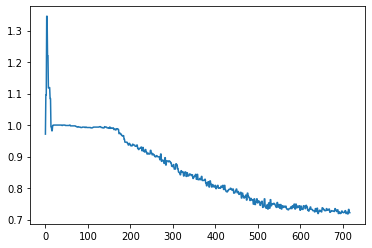

In [13]:
df['val_wer'].plot()

In [24]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
# quartznet = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_256_gamma_0_25")

In [63]:
# Bigger batch-size = bigger throughput
params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
quartznet.setup_test_data(test_data_config=params['model']['validation_ds'])
quartznet.cuda()

# first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
# first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in quartznet.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = quartznet(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        quartznet._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = quartznet._wer.compute()
        quartznet._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms) * 100}%")

NameError: name 'params' is not defined